In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
from datasets import fetch_mnist


In [16]:
# Load the mnist dataset
images_train, labels_train, images_test, labels_test = fetch_mnist()
images_train = images_train / 255.0
images_test = images_test / 255.0

In [17]:
# Model
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.sequential = nn.Sequential(
            nn.Linear(28 * 28, 128, bias=False),
            nn.ReLU(),
            nn.Linear(128, 10, bias=False),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        return self.sequential(x)


In [22]:
# Training
BATCH_SIZE = 128
model = Network()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = torch.nn.NLLLoss(reduction="none")

for i in (t := trange(1000)):
    samp = np.random.randint(0, images_train.shape[0], size=(BATCH_SIZE))

    # Inputs
    X = torch.tensor(images_train[samp].reshape((-1, 28 * 28))).float()

    # Expected outputs
    Y = torch.tensor(labels_train[samp]).long()

    model.zero_grad()

    out = model(X)
    accuracy = (torch.argmax(out, dim=1) == Y).float().mean()
    loss: torch.Tensor = loss_function(out, Y)
    loss = loss.mean()
    loss.backward()
    optim.step()

    t.set_description(f"loss {loss:.2f} accuracy {accuracy:.2f}")


loss 0.11 accuracy 0.97: 100%|██████████| 1000/1000 [00:02<00:00, 371.34it/s]


In [23]:
# Evaluation
def eval():
    X = torch.tensor(images_test[:].reshape((-1, 28 * 28))).float()
    Y = torch.tensor(labels_test[:]).long()
    out = model(X)
    accuracy = (torch.argmax(out, dim=1) == Y).float().mean()
    return accuracy.item()


print(f"accuracy: {eval()}")


accuracy: 0.9538000226020813


From label: 9
From NN: tensor([9])


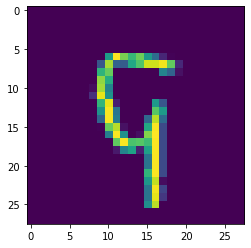

In [24]:
# Testing
import matplotlib.pyplot as plt

IDX = 62

fig, ax = plt.subplots()
ax.imshow(images_test[IDX])

x = torch.tensor(images_test[IDX].reshape(-1, 28 * 28)).float()
out = model(x)

print(f"From label: {labels_test[IDX]}")
print(f"From NN: {torch.argmax(out, dim=1)}")


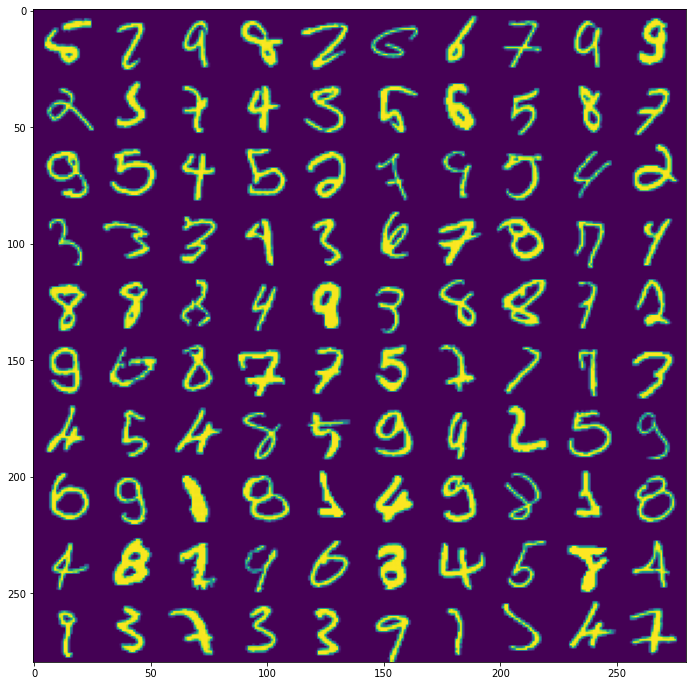

In [25]:
# Images that it did not got right
import matplotlib.pyplot as plt

G = 10

X = torch.tensor(images_test[:].reshape((-1, 28 * 28))).float()
Y = torch.tensor(labels_test[:]).long()

out = model(X)
bad_batch = [i for i, match in enumerate(torch.argmax(out, dim=1) == Y) if not match]
bad_batch = bad_batch[: G * G]

plt.figure(figsize=(12, 12))
plt.imshow(np.concatenate(images_test[bad_batch].reshape((G, G * 28, 28)), axis=1))
